# 基于MySQL的淘宝用户行为分析

本文通过对淘宝一段时间内用户行为分析，探索淘宝用户行为的规律并根据用户分类提供优化建议。

## 一、数据集介绍  
数据集来源：https://tianchi.aliyun.com/dataset/dataDetail?dataId=649&userId=1 ，包含了2017年11月25日至2017年12月3日之间，有行为的约一百万随机用户的所有行为（行为包括点击、购买、加购、喜欢）。

**字段含义**  
1. user_id：字符串类型，用户ID  
2. item_id：字符串类型，商品ID  
3. category_id：字符串类型，商品所属类目ID  
4. behavior_type：字符串，枚举类型，包括('pv', 'buy', 'cart', 'fav')  
5. timestamp	字符串类型，行为发生的时间戳  

其中用户行为有四种，分别是:  
1. pv：商品详情页pv，等价于点击  
2. buy：商品购买  
3. cart：将商品加入购物车  
4. fav：收藏商品  

关于数据集大小的一些说明如下：  
1. 用户数量：987,994
2. 商品数量：4,162,024  
3. 商品类目数量：9,439  
4. 所有行为数量：100,150,807

## 二、分析思路  
### （一）分析目的  
1. 分析用户常见电商分析指标，确定各个环节的流失率，找到需要改进的环节。  
2. 找到用户对不同种类商品的偏好，找到针对不同商品的营销策略。  
3. 研究用户在不同时间周期下的活跃规律，找到用户在不同时间尺度下的行为规律。  

### （二）提出问题  
根据现有数据及分析目的，从四个维度进行分析：  
第一个维度：用户购物情况整体分析  
以PV、UV、平均访问量、跳失率等指标，分析用户最活跃的日期及活跃时段，了解用户行为习惯。  
第二个维度：商品购买情况分析  
从成交量、人均购买次数、复购率等指标，探索用户对商品的购买偏好，了解商品的销售规律。  
第三个维度：用户行为转化漏斗分析  
从收藏转化率、购物车转化率、成交转化率，对用户行为从浏览到购买进行漏斗分析。  
第四个维度：参照RFM模型  
对用户进行分类，找出有价值的用户。  

## 三、数据清理  
### （一）数据导入  
因为数据集数据过大，为了方便分析，故选择前10万条数据，通过Navicat导入mysql数据库，进行分析。导入后的部份数据如下：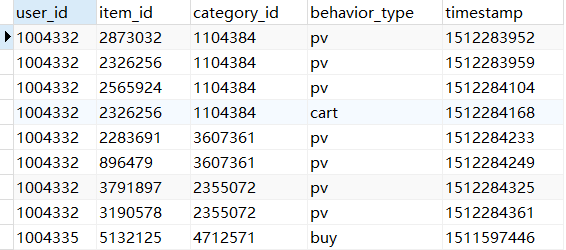

### （二）重复值筛查

In [ ]:
select count(*) 
from userbehavior
group by user_id,item_id,category_id,behavior_type,timestamp
having count(*) > 1

结果：无重复值。

### （三）筛查缺失值

In [ ]:
select 	count(user_id),count(item_id),count(category_id),count(behavior_type),count(timestamp)
from userbehavior

结果：共100000条，无缺失值。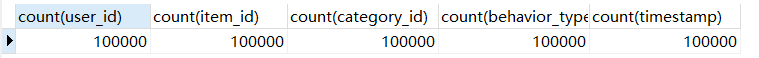

### （四）数据一致化处理  
由于 time 字段的时间包含（年-月-日）和小时，为了方便分析，将该字段分成 2 个字段，一个日期列（date）和一个小时列（time）。

In [ ]:
ALTER TABLE userbehavior ADD date VARCHAR(10);
UPDATE userbehavior SET date=FROM_UNIXTIME(timestamp,'%Y-%m-%d');
ALTER TABLE userbehavior ADD time VARCHAR(10);
UPDATE userbehavior SET time=FROM_UNIXTIME(timestamp,'%H:%i:%s');
ALTER TABLE userbehavior ADD week VARCHAR(10);
UPDATE userbehavior SET week=FROM_UNIXTIME(timestamp,'%w');
ALTER TABLE userbehavior ADD hour VARCHAR(10);
UPDATE userbehavior SET hour=FROM_UNIXTIME(timestamp,'%H');

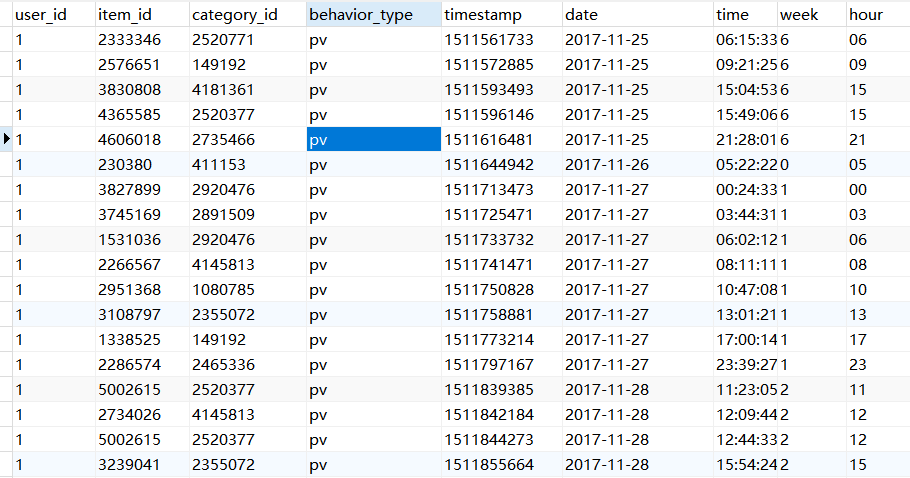

### （五）筛查异常值  
#### 1. 筛选超出数据集时间范围的数据（2017.11.25-2017.12.03）

In [ ]:
select *
from userbehavior
where date < '2017-11-25' or date > '2017-12-03'

结果：共有44条记录超出时间范围。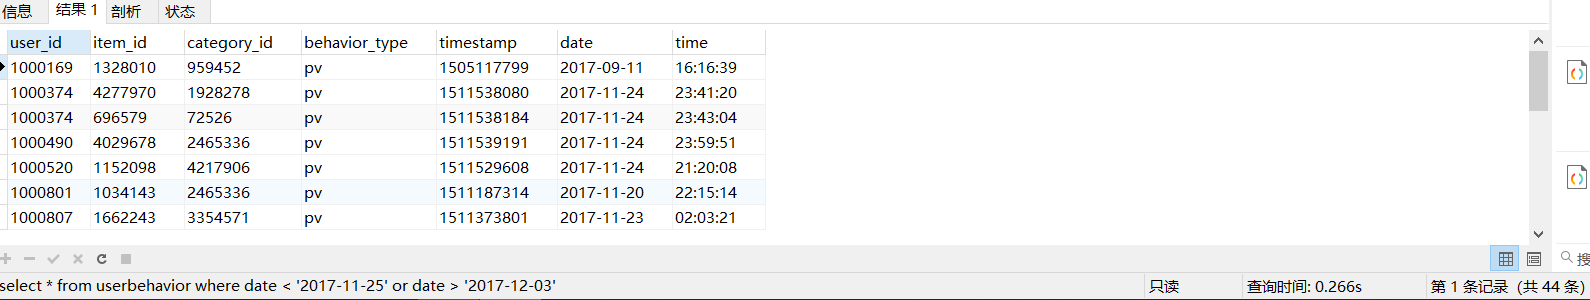

#### 2.删除超出时间范围的记录

In [ ]:
delete from userbehavior
where date < '2017-11-25' or date > '2017-12-03'

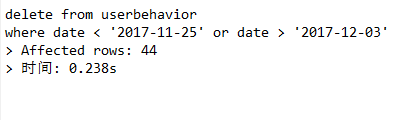

## 四、数据分析  
### （一）用户购物情况整体分析  
#### 1. pv（总访问量）

In [ ]:
select count(behavior_type) as 总访问量
from userbehavior
where behavior_type = 'pv'

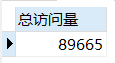

#### 2. uv（用户总数）

In [ ]:
select count(distinct user_id) as 用户总量
from userbehavior

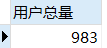

#### 3. 平均访问量  
平均访问量 = 89665/983 = 100.4

#### 4. 跳失率（跳失率：只有点击行为的用户/总用户数）

In [ ]:
select count(DISTINCT user_id) from userbehavior 
where user_id not in 
(select DISTINCT user_id from userbehavior where behavior_type='fav')
and user_id not in
(select DISTINCT user_id from userbehavior where behavior_type='cart')
and user_id not in 
(SELECT DISTINCT user_id from userbehavior where behavior_type='buy')

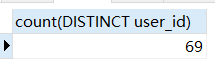  
跳失率 = 69/983 = 0.07

#### 5. 日均访问量

In [ ]:
select date,count(behavior_type) as 日均访问量 
from userbehavior
where behavior_type='pv'
GROUP BY date
ORDER BY date;

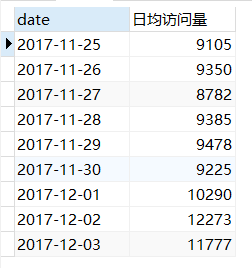

### （二）商品购买情况分分析  
#### 1. 成交量

In [ ]:
select date,count(behavior_type) as 成交量 
from userbehavior
where behavior_type='buy'
GROUP BY date;

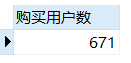

#### 3.用户的购物情况

In [ ]:
create view user_behavior as
select user_id,count(behavior_type),
sum(case when behavior_type='pv' then 1 else 0 end) as 点击次数,
sum(case when behavior_type='fav' then 1 else 0 end) as 收藏次数,
sum(case when behavior_type='cart' then 1 else 0 end) as 加购次数,
sum(case when behavior_type='buy' then 1 else 0 end) as 购买数
from userbehavior
group by user_id
order by count(behavior_type) desc;

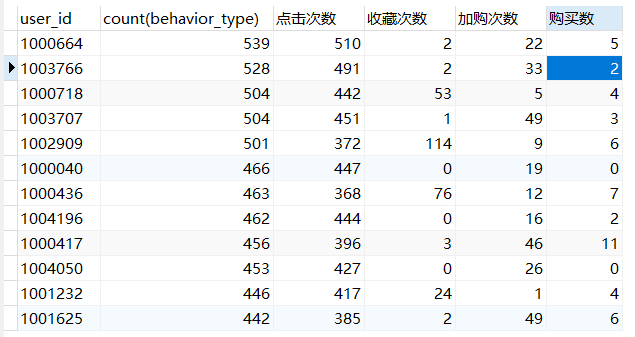

#### 4.复购率：产生两次或两次以上购买行为的用户占购买用户的比例

In [ ]:
select sum(case when 购买数>1 then 1 else 0 end) as 购买数大于1次,
sum(case when 购买数>0 then 1 else 0 end) as 总购买数,
concat(round(sum(case when 购买数>1 then 1 else 0 end)/sum(case when 购买数>0 then 1 else 0 end)*100,2),'%') as 复购率
from user_behavior;

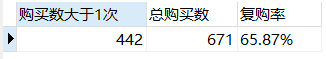

#### 5.重复购买次数最多的客户

In [ ]:
select user_id,count(user_id) 
from userbehavior
where behavior_type='buy'
GROUP BY user_id
ORDER BY count(user_id) desc
limit 10;

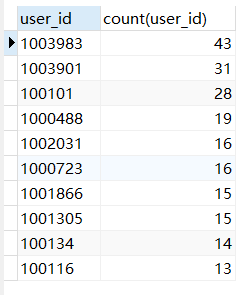

#### 6.重复被购买次数最多的商品

In [ ]:
select item_id,count(behavior_type) as 被购买次数 
from userbehavior
where behavior_type='buy'
GROUP BY item_id
ORDER BY 被购买次数 desc
limit 10;

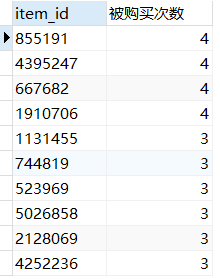

#### 7.购买率高和购买率低的用户各有什么特征  
**(1)购买率高的用户特征**

In [ ]:
select user_id,点击次数,收藏次数,加购次数,购买数,round(购买数/点击次数*100,2) as 购买率
from user_behavior
GROUP BY user_id
ORDER BY 购买率 desc;

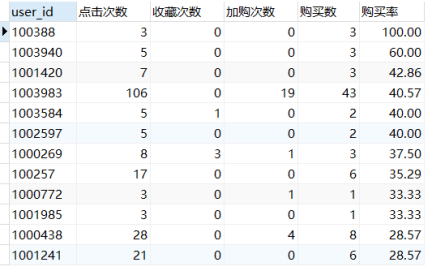  
由以上结果可以看出，购买率高的用户点击率反而不是最多的，这些用户收藏数和加购物车的次数也很少，一般不点击超过5次就直接购买，由此可以推断出这些用户为理智型消费者，有明确的购物目标，属于缺啥买啥型，很少会被店家广告或促销吸引。

**（2）购买率低的用户特征**  
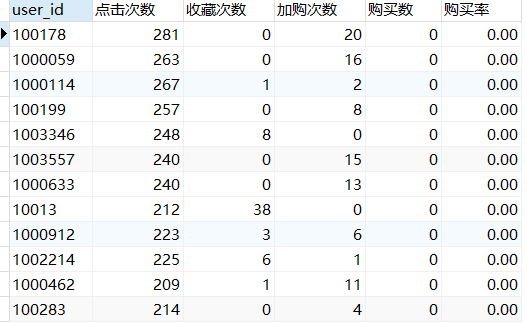  
由以上结果可以看出，购买率为低用户，他的点击率高、收藏或加购物车也多，此类用户可能正为商家的促销活动做准备，下单欲望较少且自制力较强，思虑多或者不会支付，购物难度较大。

#### 8.用户整体行为在时间维度的分布情况  
**（1）用户每日浏览量**

In [ ]:
SELECT date,count(date) AS 每日浏览量
FROM userbehavior 
WHERE behavior_type = 'pv'
GROUP BY date;

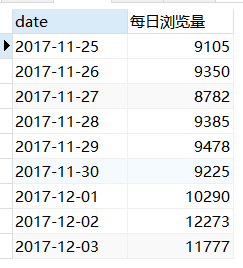  
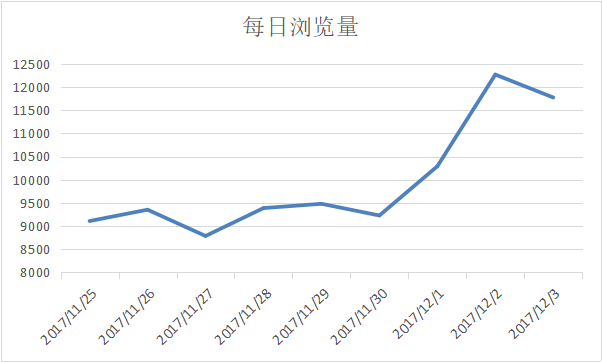  
从点击量的变化趋势来看，11/25-11/30这几天点击量差别不大，但从12/1-12/3一路上升，在2号达到最高。

**（2）日销量**

In [ ]:
SELECT date,count(date) AS 日销量
FROM userbehavior 
where behavior_type = 'buy'
GROUP BY date;

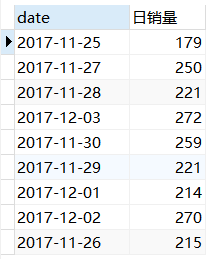  
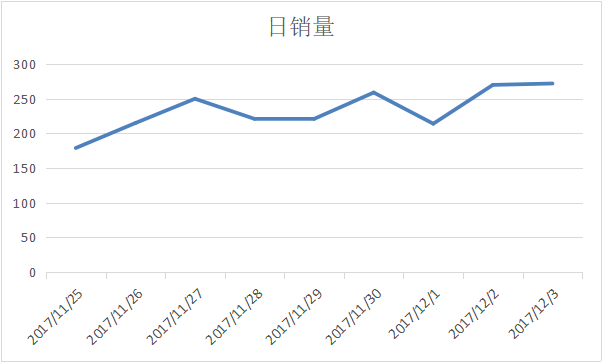  
从图中看出，销量和点击量有所不同，处于一个高低起伏的状态，说明点击量多的商品并不一定是购买最多的商品，这个猜测会在接下来进一步分析；日销量的这张图有四个峰点，分别是11/27,11/30，12/2和12/3，其中12/3销量最高，而2号和3号正好是周末，猜测原因是周末用户有更多的时间来浏览网站进行购买。

**（3）一天中用户的活跃时段分布**
为了进一步分析用户偏好在哪个时间段进行浏览、购买，分别对每个时间段的点击量和销量进行了统计。

In [ ]:
select hour,
sum(case when behavior_type='pv' then 1 else 0 end) as 点击次数
FROM userbehavior
GROUP BY hour
ORDER BY hour;

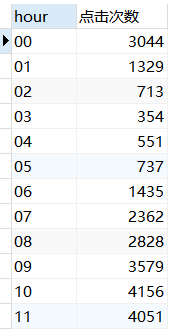  
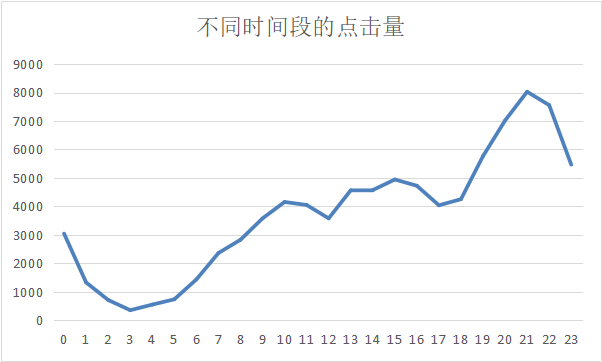

In [ ]:
select hour,
sum(case when behavior_type='buy' then 1 else 0 end) as 购买次数
FROM userbehavior
GROUP BY hour
ORDER BY hour;

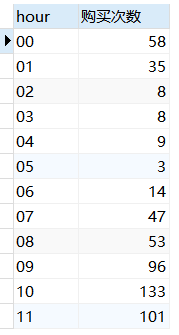  
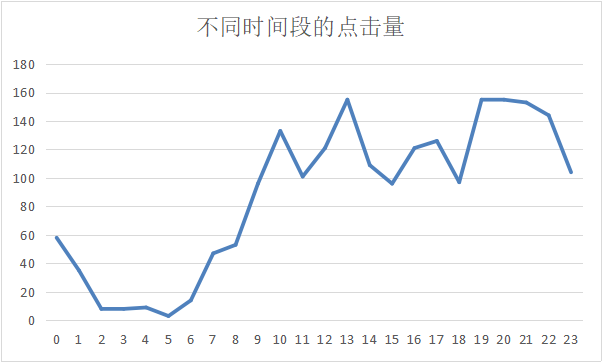  
从图中发现，点击量和销量的变化趋势类似，都是6点开始随着时间逐步提高，在10点到达最高峰。

### （三）用户用为转化漏斗  
#### 1.用户购买行为计数

In [ ]:
select sum(点击次数) as 总点击数,sum(收藏次数) as 收藏总数,sum(加购次数) as 加购物车总数,
sum(购买数) as 购买总数 
from user_behavior;

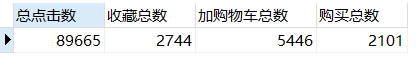

#### 2.计算整体转化率  
在购物环节中收藏和加入购物车两个环节没有先后之分，所以将这两个环节可以放在一起作为购物环节的一步。最终得到用户购物行为的整体转化率，如下：

In [ ]:
SELECT CONCAT(ROUND(SUM(点击次数)/SUM(点击次数)*100,2),'%') AS pv,
CONCAT(ROUND((SUM(加购次数)+SUM(收藏次数))/SUM(点击次数)*100,2),'%') AS pv_to_favCart,
CONCAT(ROUND(SUM(购买数)/SUM(点击次数)*100,2),'%') AS pv_to_buy
from user_behavior;

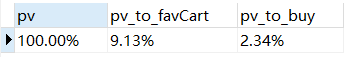

#### 3.计算环节转化率

In [ ]:
SELECT CONCAT(ROUND(SUM(点击次数)/SUM(点击次数)*100,2),'%') AS pv,
CONCAT(ROUND((SUM(加购次数)+SUM(收藏次数))/SUM(点击次数)*100,2),'%') AS pv_to_favCart,
CONCAT(ROUND(SUM(购买数)/(SUM(加购次数)+SUM(收藏次数))*100,2),'%') AS favCart_to_buy
from user_behavior;

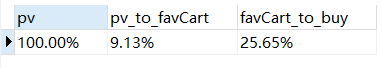  
#### 4.得到用户购买行为的漏斗图  
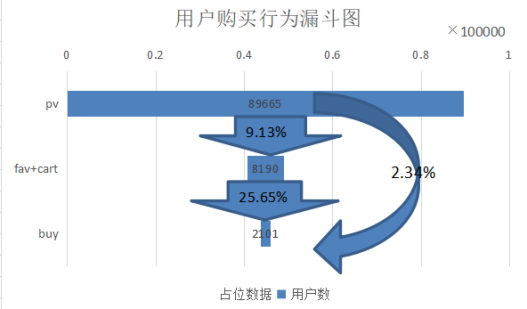  
整体来看，购买转化率较低。尤其在浏览到加入购物车/收藏这一环节，转化率只有9.13%，大部分浏览行为并没有转化为购买意向。由此可见，造成用户大量流失的环节主要在加入购物车和收藏这一步，商家需要针对这个阶段重点提升。

### （四）参照RFM模型  
通过点击次数与购买数对用户进行分类

In [ ]:
SELECT user_id,
(CASE WHEN (点击次数>92) AND (购买数>5) THEN 'AA'
WHEN (点击次数>92) AND (购买数<=5) THEN 'AB'
WHEN (点击次数<=92) AND (购买数>5) THEN 'BA'
WHEN (点击次数<=92) AND (购买数<=5) THEN 'BB'
END) AS 'Level'
FROM user_behavior;

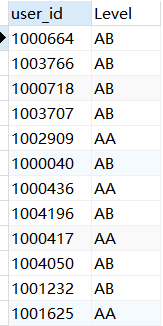  
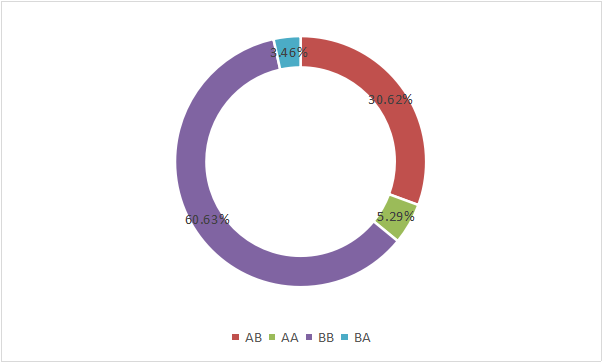  
* AA：价值用户，浏览量和购买量均高于平均水平  
* AB：活跃用户，浏览量高，购买量低  
* BA：保持用户，浏览量低，购买量高  
* BB：潜在用户，浏览量和购买量均低于平均水平

## 五、结论
1. 总体转化率只有 2.34%，用户点击后收藏和加购物车的转化率在 9.13% ，需要提高用户的购买意愿，建议通过活动、优惠券、产品详情页的改进等提高转化率。  
2. 这段时间，复购率达到65.87%，说明店铺产品对用户吸引力比较大。  
3. 商品编号855191购买次数达到4次，对于复购率高的商品，建议可以建立自己的忠实粉丝群，实行更精准的人群管理。  
4. 用户11003983购买次数达到43次，对于这类忠实的用户需要开发用户信息库，建立完善的用户资料库，记录客户购物情况。  
5. 大部分用户的主要活跃时间在10点到23点，在19点到23点达到一天的顶峰。可以根据用户的活跃时间段精准推送商家的折扣优惠或促销活动，提高购买率。  
6. 12月2日与12月3日，相对于其他日期，流量增长明显，说明周末会有更多人使用淘宝，商家可以在周末推出更多促销活动吸引用户。  
7. 通过对浏览量和购买量的分析，可以针对不同群体进行精准营销：  
（1）价值用户：这部分用户对淘宝依赖度极高，浏览量和购买量双双较大，是淘宝的重度依赖用户，也对利润的主要人群。这部分用户要重点保持和维护，流量与销量都与此部分人群联系较大，减少流失；  
（2）活跃用户：这部分用户浏览量很大，但是购买量较低。根据行为角度的分析来看，需要优化推送机制，丰富整个APP的趣味性，尽量将流量转化为销量；  
（3）保持用户：这部分用户购买量大，但是浏览量低，推测是不爱好刷淘宝，是目的很明确有购买意向的用户。针对这部分用户需要精简推送页面，精准推送内容；  
（4）潜在用户：这部分用户浏览量和购买量都比较低，非淘宝依赖用户。可以通过首单优惠或浏览奖励等方式培养用户在淘宝浏览和购物的习惯。